# Milestone 2 
Initial analysis and data handling pipeline for the project. 
The notebook is structured in the following way:
- Loading data
- Data wrangling
- Data analysis for the research questions
    - Regarding the articles structure
        * Q1: How different are the length of these articles and their number of hyperlinks?
        * Q2: How positive or negative is the content of an article and the articles linked to it?
    - Regarding the pathways
        * Q3: Is there a correlation between the ratio of finished pathways and the country?
        * Q4: Is there a correlation between the length of the pathway taken respectively the time needed and the country?
    - Regarding confounding variables
        * Q5: By investigating article length, article sentiment or number of hyperlinks while controlling for e.g. population size, economic power or if English is an official language, is there a representation bias based on countries in Wikipedia?  
        * Q6: While controlling for as much of the bias in the dataset as we can, do we see additional bias of the players in the pathways they have taken?
    
    
    To compare all countries (more than 200) would be too confusing, therefore they are grouped by region/continent and by economic developement.


## Loading data


In [334]:
# Loading all the necessary packages
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.offsetbox import AnchoredText
from urllib.parse import unquote
import seaborn as sns
import networkx as nx
#import plotly.express as px
#import plotly.graph_objects as go
import statsmodels.formula.api as smf
import scipy.stats as stats
from urllib.parse import unquote

In [335]:
articles =  pd.read_csv("data/wikispeedia_paths-and-graph/articles.tsv", sep='\t', names=["article"], skiprows=12)
links = pd.read_csv("data/wikispeedia_paths-and-graph/links.tsv", sep='\t', names=["link_source", "link_target"], skiprows = 12)
paths_finished = pd.read_csv("data/wikispeedia_paths-and-graph/paths_finished.tsv", sep='\t', names=["hashedIpAddress", "timestamp", 
                                                              "durationInSec", "path", "rating"], skiprows = 15)
paths_unfinished = pd.read_csv("data/wikispeedia_paths-and-graph/paths_unfinished.tsv", sep='\t', names=["hashedIpAddress", "timestamp", 
                                                                  "durationInSec", "path", "target", "type"], skiprows = 17)
shortest_distance_text = np.loadtxt("data/wikispeedia_paths-and-graph/shortest-path-distance-matrix.txt", dtype=str, comments="#", unpack=False)
categories= pd.read_csv("data/wikispeedia_paths-and-graph/categories.tsv", sep='\t', names=["article", "category"], skiprows = 13)

# seperate each row and create a matrix with all the shortest distance
table_distance = np.array([[int(c) if c != '_' else -1 for c in row] for row in shortest_distance_text])

UN_countries = pd.read_csv("data/UNSD — Methodology.csv", delimiter = ';')
UN_countries_by_economies_load = pd.read_csv("data/countries_by_income_category.csv")
UN_countries_by_economies_load.columns = ['Country or Area', 'Economic classification']

In [336]:
def seperate_path(path):
    # Split the path into individual articles
    articles = path.split(";")
    
    # Extract source and target
    source, target = articles[0], articles[-1]
    
    # Calculate the length, considering back-clicks
    length = len(articles) + articles.count('') - 1
    
    return source, target, length

# Find the index of an article in the helper DataFrame
def find_article_index(article, helper_df):
    try:
        return helper_df.loc[article]
    except KeyError:
        return None

# Calculate the shortest distance between source and target indices
def calculate_shortest_distance(source_idx, target_idx):
    try:
        return table_distance[source_idx, target_idx][0]
    except KeyError:
        return None

# Finding the shortest path length between a source and a target
def find_path_distance(source, target, helper_df):
    source_idx = find_article_index(source, helper_df)
    target_idx = find_article_index(target, helper_df)

    if source_idx is not None and target_idx is not None:
        return calculate_shortest_distance(source_idx, target_idx)
    else:
        # Handle the case where source or target is not present in the index
        return None

def extract_subject_category(category):
    # Split the category string by '.'
    category_parts = category.split('.')
    
    # Find the index of 'subject' in the split parts
    subject_index = category_parts.index('subject')
    
    # Check if there is at least one word after 'subject'
    if subject_index < len(category_parts) - 1:
        return category_parts[subject_index + 1] 

## Data wrangling 
We now parse and transform the data into appropriate data model and format that will be used for the analysis we want to do. For instance article titles are transformed to a readable format, paths are expanded so that we may build a dataframe that gives an overwiew of the paths.


In [337]:
# Translating all article titles to user readable format
articles['article'] = articles['article'].apply(unquote)
links['link_source'] = links['link_source'].apply(unquote)
links['link_target'] = links['link_target'].apply(unquote)
paths_finished['path'] = paths_finished['path'].apply(unquote)
paths_unfinished['path'] = paths_unfinished['path'].apply(unquote)
paths_unfinished['target'] = paths_unfinished['target'].apply(unquote)
categories['article'] = categories['article'].apply(unquote)

In [338]:
# expand the finished paths
path_fin = paths_finished.copy()
path_fin = path_fin.assign(source=paths_finished['path'].apply(lambda x: seperate_path(x)[0]),
                           target=paths_finished['path'].apply(lambda x: seperate_path(x)[1]),
                           game_path=paths_finished['path'].apply(lambda x: seperate_path(x)[2]),
                           completed=True)

# expand the unfinished paths
path_ufin = paths_unfinished.copy()
path_ufin = path_ufin.assign(source=paths_unfinished['path'].apply(lambda x: seperate_path(x)[0]),
                             failure_article=paths_unfinished['path'].apply(lambda x: seperate_path(x)[1]),
                             game_path=paths_unfinished['path'].apply(lambda x: seperate_path(x)[2]),
                             completed=False,
                             target=paths_unfinished["target"])

# construct a new dataframe: path_overview
path_overview = pd.concat([path_fin, path_ufin], ignore_index=True)[["source", "target",  "hashedIpAddress", "timestamp",
                                                                     "durationInSec", "game_path",
                                                                     "completed", "rating","type"]]
path_overview.head()

,source,target,hashedIpAddress,timestamp,durationInSec,game_path,completed,rating,type
0,14th_century,African_slave_trade,6a3701d319fc3754,1297740409,166,8,True,NaN,NaN
1,14th_century,African_slave_trade,3824310e536af032,1344753412,88,4,True,3.0,NaN
2,14th_century,African_slave_trade,415612e93584d30e,1349298640,138,7,True,NaN,NaN
3,14th_century,Greece,64dd5cd342e3780c,1265613925,37,3,True,NaN,NaN
4,14th_century,John_F._Kennedy,015245d773376aab,1366730828,175,6,True,3.0,NaN


In [339]:
articles["index"] = articles.index
help_articles = articles.set_index("article")

# shortest path length is added to the path_overview
# Create a copy of the 'path_overview' DataFrame to avoid modifying the original
path_overview_copy = path_overview.copy()

# Apply the find_path_distance function to each row
path_overview_copy['shortest_distance'] = path_overview_copy.apply(
    lambda row: find_path_distance(row['source'], row['target'], help_articles), axis=1
)

# Update the original 'path_overview' DataFrame with the new 'shortest_distance' column
path_overview['shortest_distance'] = path_overview_copy['shortest_distance']

In [340]:
#remove all rows where the source or target article is not among the available articles in the dataset
path_overview = path_overview.drop(path_overview[~(path_overview['source'].isin(articles['article'].array))].index)
path_overview = path_overview.drop(path_overview[~(path_overview['target'].isin(articles['article'].array))].index)

# remove all rows where there is no path between the source article and target article
path_overview = path_overview.drop(path_overview[path_overview['shortest_distance'] == -1].index) 
path_overview.insert(4, 'shortest_distance', path_overview.pop('shortest_distance'))

# Translating article names from URL to latin characters
path_overview['source'].apply(unquote)
path_overview['target'].apply(unquote)

display(path_overview)

,source,target,hashedIpAddress,timestamp,shortest_distance,durationInSec,game_path,completed,rating,type
0,14th_century,African_slave_trade,6a3701d319fc3754,1297740409,3.0,166,8,True,NaN,NaN
1,14th_century,African_slave_trade,3824310e536af032,1344753412,3.0,88,4,True,3.0,NaN
2,14th_century,African_slave_trade,415612e93584d30e,1349298640,3.0,138,7,True,NaN,NaN
3,14th_century,Greece,64dd5cd342e3780c,1265613925,2.0,37,3,True,NaN,NaN
4,14th_century,John_F._Kennedy,015245d773376aab,1366730828,3.0,175,6,True,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...
76188,Franz_Kafka,Cholera,109ed71f571d86e9,1389787605,3.0,180,7,False,NaN,restart
76189,Modern_history,Hollandic,232f992e57d43e8d,1389787697,3.0,6,0,False,NaN,restart
76190,Computer_programming,The_Beatles,2e09a7224600a7cd,1389798400,3.0,1900,4,False,NaN,timeout
76191,Jamaica,Alan_Turing,60af9e2138051b96,1389799481,3.0,1903,3,False,NaN,timeout


Another data wrangling step is to build a dataframe that contains the main categories of the articles.

In [341]:
# Apply the custom function extract_subject_category() to create a new 'subject_category' column
categories['subject_category'] = categories['category'].apply(extract_subject_category)

# Create a dataFrame with only the relevant columns
main_categories = categories[['article', 'subject_category']]

# Display the new DataFrame
main_categories.head()

,article,subject_category
0,Áedán_mac_Gabráin,History
1,Áedán_mac_Gabráin,People
2,Åland,Countries
3,Åland,Geography
4,Édouard_Manet,People


Finally, we build a dictionary that maps articles country names to country names of the UN dataset and one that maps countries to their continent (world region).

In [374]:
# Below we find the articles which have different names to those outlined in the UN dataset. We then manually found the corresponding name in the UN
# dataset and created a dictionary to map article names -> UN dataset name

countries = main_categories[main_categories['subject_category'] == 'Countries']['article'].values
countries = [cntry.replace('_',' ') for cntry in countries]

# United Arab Emirates Problem -> Abu Dhabi / Dubai are not countries etc. If confusion, the country with biggest population is kept
countries_to_remove = ['Abu Dhabi', 'Dubai', 'Easter Island', 'Galápagos Islands', 'Korea', 'Abkhazia', 'Republic of China']
countries = [cntry for cntry in countries if cntry not in countries_to_remove]

countries_missing = []

for country in countries:
    country = country.replace('_',' ')
    if country not in UN_countries['Country or Area'].values:
        countries_missing.append(country)

# "China Problem" we keep Taiwan  -> Taiwan, Republic of China -> deleted (same as Taiwan),
# Tibet -> Tibet, People's Republic of China -> China

replacement_country_names = [
    'Åland Islands', 'Ireland', 'Bolivia (Plurinational State of)',
    'Brunei Darussalam', 'Côte d’Ivoire', 'Cabo Verde', 'Czechia',
    'Timor-Leste', 'Falkland Islands (Malvinas)', 'Micronesia (Federated States of)',
    'State of Palestine', 'Georgia', 'China, Hong Kong Special Administrative Region',
    'Iran (Islamic Republic of)', '', 'Lao People\'s Democratic Republic', 
    'Republic of Moldova', 'Netherlands (Kingdom of the)', 'Sint Maarten (Dutch part)', 
    'Democratic People\'s Republic of Korea', 'State of Palestine', 'China', 'Ireland',
    'North Macedonia', 'Russian Federation', 'Sao Tome and Principe', 'Serbia', 'Republic of Korea',
    "", 'Eswatini', 'Syrian Arab Republic', 'United Republic of Tanzania', 'Bahamas',
    'Gambia', 'Tibet', 'Türkiye', 'Turkish Republic of Northern Cyprus', 'United Kingdom of Great Britain and Northern Ireland',
    'United States of America', 'Holy See', 'Venezuela (Bolivarian Republic of)', 'Viet Nam', 'State of Palestine'
]

replacement_countries = dict(zip(countries_missing, replacement_country_names))

In [380]:
def get_region(country, DataFrame_with_regions, names_to_replace):
    """
    Returns the region for country, using names_to_replace for those with different names in DataFram_with_region than in the Wikispeedia Dataset
    """
    country = country.replace('_',' ')
    if country in DataFrame_with_regions['Country or Area'].values:
        region = DataFrame_with_regions[DataFrame_with_regions['Country or Area'] == country]['Region Name'].values
        # print(type(region))
        return region[0]
    elif names_to_replace.get(country) != None:
        new_country = names_to_replace[country]
        region = DataFrame_with_regions[DataFrame_with_regions['Country or Area'] == new_country]['Region Name'].values
        if len(region) > 0:
            return region[0]
        else:
            return ""
    else:
        return np.nan

# Creating a dictionary to map each country to its continent (region).
country_to_region = {}

for country in countries:
    country_to_region[country] = get_region(country, UN_countries, replacement_countries)

# 'Kosovo' and 'South_Ossetia' are added manually as they are not present in the UN dataframe.
country_to_region['Kosovo'] = 'Europe'
country_to_region['South_Ossetia'] = 'Asia'

df_country_region = pd.DataFrame.from_dict(country_to_region, 
                                           orient='index',
                                           dtype=None,
                                           columns=['region'])

df_country_region.reset_index(inplace=True)
df_country_region.rename(columns={"index": "article"}, inplace=True)

In [392]:
# Create UN_countries_by_economies DataFrame

# hard coded changes in country names that can't be read properly from the .csv file
read_csv_names = ['Turkiye', 'China Hong Kong Special Administrative Region', 'Cote d Ivoire']
new_names = ["Türkiye", "China, Hong Kong Special Administrative Region", "Côte d’Ivoire"]
UN_to_modify = UN_countries_by_economies_load.copy()
for i in range(len(read_csv_names)-1):
    country_index = np.where(UN_countries_by_economies_load['Country or Area']==read_csv_names[i])[0][0]
    UN_to_modify.at[country_index, 'Country or Area'] = new_names[i]

UN_countries_by_economies = pd.merge(UN_countries, UN_to_modify, how='left', on='Country or Area')[['Country or Area', 'Least Developed Countries (LDC)', 'Land Locked Developing Countries (LLDC)', 'Small Island Developing States (SIDS)', 'Economic classification']]
# Show countries that are missing an economic classification (should be 248-163=85)
# missing_countries = UN_countries_by_economies[UN_countries_by_economies['Economic classification'].isna()]['Country or Area'].values

# Rename Countries to match the names of English Wikipedia
replacement_countries_OLD_NEW = dict([(value, key) for key, value in replacement_countries.items()])
UN_countries_by_economies['Country or Area'] = UN_countries_by_economies['Country or Area'].map(replacement_countries_OLD_NEW).fillna(UN_countries_by_economies['Country or Area'])
UN_countries_by_economies = UN_countries_by_economies.sort_values('Country or Area').reset_index(drop=True)

# Check if everything went fine
display(UN_countries_by_economies[UN_countries_by_economies['Country or Area'] == "Taiwan"])
display(UN_countries_by_economies)

,Country or Area,Least Developed Countries (LDC),Land Locked Developing Countries (LLDC),Small Island Developing States (SIDS),Economic classification
214,Taiwan,NaN,NaN,NaN,High-income


,Country or Area,Least Developed Countries (LDC),Land Locked Developing Countries (LLDC),Small Island Developing States (SIDS),Economic classification
0,Afghanistan,x,x,NaN,NaN
1,Albania,NaN,NaN,NaN,Upper middle income
2,Algeria,NaN,NaN,NaN,Upper middle income
3,American Samoa,NaN,NaN,x,NaN
4,Andorra,NaN,NaN,NaN,NaN
...,...,...,...,...,...
244,Western Sahara,NaN,NaN,NaN,NaN
245,Yemen,x,NaN,NaN,Lower middle income
246,Zambia,x,x,NaN,Lower middle income
247,Zimbabwe,NaN,x,NaN,Low-income


In [393]:
# Create np.array with name of all articles that are about a country
countries = main_categories[main_categories['subject_category'] == 'Countries']['article'].values

# Directory where the .txt files are stored
directory = "data/plaintext_articles/" 

# Initialize an empty list to store the data
data = []

# Iterate over all countries
for country in countries:
    file_path = directory + country + '.txt'

# Open the file and read its content into a string
    if os.path.exists(file_path):
        with open(file_path, 'r', encoding='utf-8') as file:
            load_file_content = file.read()
            file_content = load_file_content[15:].replace("\n\n2007 Schools Wikipedia Selection", "")

    # Add filname, content and article length to the data list
        data.append((country, file_content, len(file_content)))

# Create a DataFrame from the data list
plaintext_articles = pd.DataFrame(data, columns=['Country', 'Article content', 'Article length'])

# Display the DataFrame
display(plaintext_articles)

,Country,Article content,Article length
0,Abkhazia,Abkhazia. Related subjects: Asian Countries;\n...,33592
1,Abu_Dhabi,Abu Dhabi. Related subjects: Countries; Middle...,12072
2,Afghanistan,Afghanistan. Related subjects: Asian Countries...,40240
3,Albania,Albania. Related subjects: Countries; European...,24203
4,Algeria,Algeria. Related subjects: African Countries;\...,34081
...,...,...,...
215,West_Bank,West Bank. Related subjects: Countries; Middle...,38456
216,Western_Sahara,Western Sahara. Related subjects: African Coun...,25959
217,Yemen,Yemen. Related subjects: Countries; Middle Eas...,28075
218,Zambia,Zambia. Related subjects: African Countries;\n...,31103


## Data analysis
We now focus on perfoming descriptive statistics and initial analysis that supports our research questions.


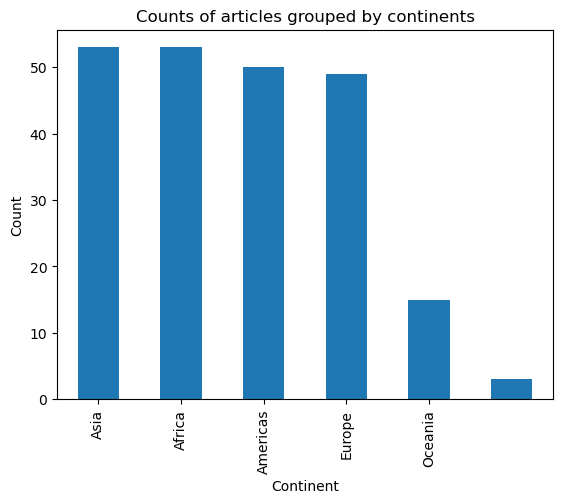

In [394]:
# Plotting the distribution of countries in the dataset based on their continent, which we will consider their region.
continents_count = pd.DataFrame(country_to_region.values()).value_counts()

continents_count.plot(kind='bar')
xticks = ["Asia", "Africa", "Americas", "Europe", "Oceania"]
l = [0,1,2,3,4]

plt.xticks(l, xticks)
plt.title("Counts of articles grouped by continents")
plt.xlabel("Continent")
plt.ylabel("Count")
plt.show()

This view of the number of country related articles by continent reflects that there is a reasonble number of articles present in the data set to perform our research.

## First research questions
We focus on the Wikipedia articles about countries and their hyperlink structure in the Wikispeedia dataset.
### Summary statistics for the number of in- and out- degrees of each region 

In [395]:
links_outdegree = links.copy()
links_outdegree.columns = ['article','link_out']
out_degrees = links_outdegree.groupby('article').count()
out_degrees.sort_values(by='link_out', ascending=False, inplace=True)

links_indegree = links.copy()
links_indegree.columns = ['link_in','article']
in_degrees = links_indegree.groupby('article').count()
in_degrees.sort_values(by='link_in', ascending=False, inplace=True)

link_counts = out_degrees.merge(in_degrees, how='outer', on='article')

In [396]:
country_links = link_counts[link_counts.index.isin(countries)]
country_links.reset_index(inplace=True)
country_links = country_links.merge(df_country_region, on='article', how='left')
country_links.head()

,article,link_out,link_in,region
0,United_States,294.0,1551.0,NaN
1,Lebanon,192.0,114.0,Asia
2,Armenia,186.0,99.0,Asia
3,Georgia_(country),180.0,84.0,NaN
4,Turkey,172.0,249.0,Asia


In [397]:
# Initialising empty dataframes
link_out_summary = pd.DataFrame()
link_in_summary = pd.DataFrame()

# Getting summary statistics for each region for in- and out- degrees
links_means = country_links[['link_out','link_in','region']].groupby(['region']).mean()
links_std = country_links[['link_out','link_in','region']].groupby(['region']).std()
links_max = country_links[['link_out','link_in','region']].groupby(['region']).max()
links_median = country_links[['link_out','link_in','region']].groupby(['region']).median()

for df, kind in [(links_means, 'mean'), (links_median, 'median'), (links_std, "std"), (links_max, 'max')]:
    link_out_summary[kind] = df['link_out']
    link_in_summary[kind] = df['link_in']

In [398]:
print("Link in descriptive statistics")
display(link_in_summary)

Link in descriptive statistics


,mean,median,std,max
region,,,,
,62.000000,62.0,NaN,62.0
Africa,84.487805,74.0,50.553992,362.0
Americas,96.562500,64.5,106.606886,571.0
Asia,139.390244,99.0,133.257622,611.0
Europe,214.358974,151.0,204.560696,959.0
Oceania,110.857143,37.0,199.519781,563.0


In [399]:
print("Link out descriptive statistics")
display(link_out_summary)

Link out descriptive statistics


,mean,median,std,max
region,,,,
,29.000000,29.0,NaN,29.0
Africa,69.195122,44.0,49.799207,162.0
Americas,46.757576,40.0,28.070258,163.0
Asia,65.780488,49.0,47.260720,192.0
Europe,72.731707,61.0,38.555171,169.0
Oceania,36.571429,28.0,21.983760,86.0


Here the number of links in and out appears to vary significantly within countries and continent, this variation could be correlated to the article length or else, which supports our first research question.

## Second section of research questions
The focus is on the pathways that were taken by the players, where the target or goal article of the game is a country.
### Finished paths and target countries

In [400]:
country_path_overview = path_overview[path_overview['target'].isin(countries)]

country_path_overview = country_path_overview.merge(df_country_region, 
                                                    left_on='target', 
                                                    right_on='article', 
                                                    how='left').drop(['article'], axis=1)

In [401]:
region_completed_count = country_path_overview[['region','completed','target']].groupby(['region','completed']).count()
region_count = country_path_overview[['region','target']].groupby(['region']).count()
# region_completed_count.set_index(['region'], inplace=True)
region_count

,target
region,
,20
Africa,713
Americas,724
Asia,1115
Europe,977
Oceania,107


Each continent is reasonably represented in terms of number of times it was a target of the game, this supports the fact that should be enough data for us to analysis the ratio of finished/unfinished pathways.

In [402]:
proportions = pd.DataFrame()

for region, completion in region_completed_count.index:
    proportion = region_completed_count.loc[(region, completion)] / region_count.loc[region]
    if completion:
        status = 'finished'
    else:
         status = 'unfinished'
    print(f"Proportion of {status} paths with {region} as target: {round(proportion.values[0]*100,4)}%")

Proportion of unfinished paths with  as target: 15.0%
Proportion of finished paths with  as target: 85.0%
Proportion of unfinished paths with Africa as target: 11.3604%
Proportion of finished paths with Africa as target: 88.6396%
Proportion of unfinished paths with Americas as target: 12.5691%
Proportion of finished paths with Americas as target: 87.4309%
Proportion of unfinished paths with Asia as target: 12.1076%
Proportion of finished paths with Asia as target: 87.8924%
Proportion of unfinished paths with Europe as target: 9.2119%
Proportion of finished paths with Europe as target: 90.7881%
Proportion of unfinished paths with Oceania as target: 20.5607%
Proportion of finished paths with Oceania as target: 79.4393%


Basic statistics representing the ratio of finished vs unfinished paths towards a country of a specific continent already reflects some difference between the continents. Europe and Africa have the highest finish rate in front of Asia, Oceania and Americas, interestingly Africa was almost two times less a target as Asia. Further correlation test such as the Pearson correlation test could be applied to answer the 3rd research question.

### Length of pathway analysis

In [403]:
regions_paths = country_path_overview[['region','shortest_distance','game_path']][country_path_overview['completed']==True].groupby(by=['region','shortest_distance']).mean().reset_index()

In [404]:
regions_paths_1 = regions_paths[regions_paths['shortest_distance'] == 1]
regions_paths_2 = regions_paths[regions_paths['shortest_distance'] == 2]
regions_paths_3 = regions_paths[regions_paths['shortest_distance'] == 3]
regions_paths_4 = regions_paths[regions_paths['shortest_distance'] == 4]

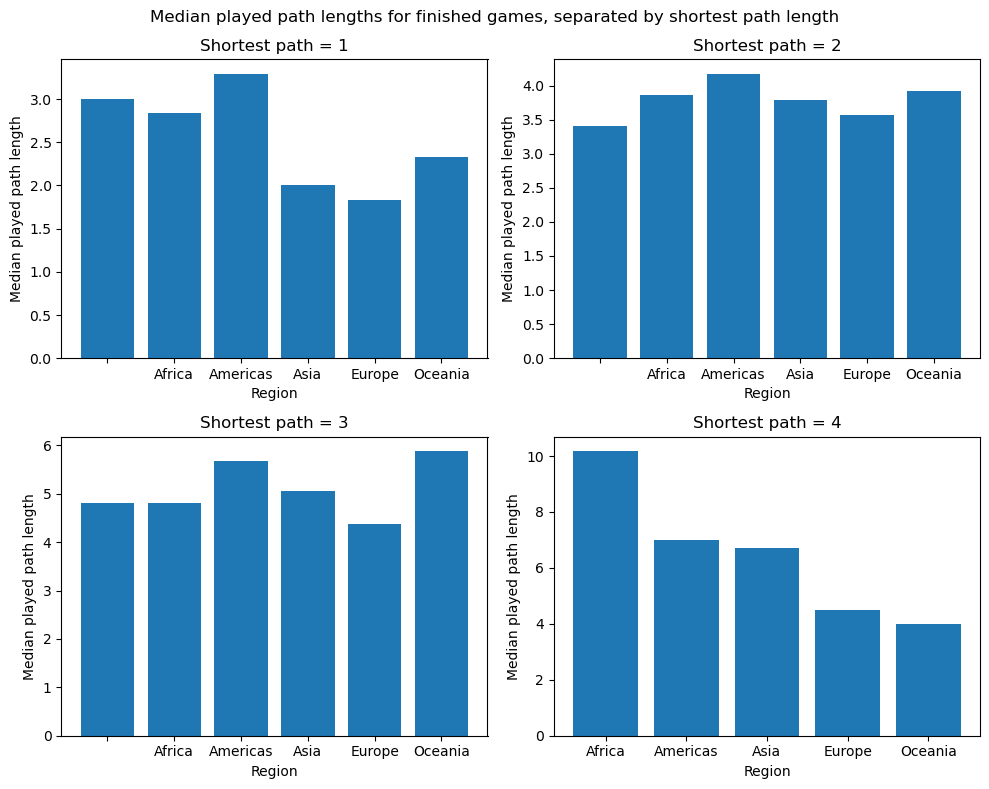

In [405]:
figs, axs = plt.subplots(2,2, figsize=(10,8))

figs.suptitle("Median played path lengths for finished games, separated by shortest path length")

axs[0,0].bar(regions_paths_1['region'], regions_paths_1['game_path'])
axs[0,0].set_title("Shortest path = 1")
axs[0,0].set_xlabel("Region")
axs[0,0].set_ylabel("Median played path length")

axs[0,1].bar(regions_paths_2['region'], regions_paths_2['game_path'])
axs[0,1].set_title("Shortest path = 2")
axs[0,1].set_xlabel("Region")
axs[0,1].set_ylabel("Median played path length")

axs[1,0].bar(regions_paths_3['region'], regions_paths_3['game_path'])
axs[1,0].set_title("Shortest path = 3")
axs[1,0].set_xlabel("Region")
axs[1,0].set_ylabel("Median played path length")

axs[1,1].bar(regions_paths_4['region'], regions_paths_4['game_path'])
axs[1,1].set_title("Shortest path = 4")
axs[1,1].set_xlabel("Region")
axs[1,1].set_ylabel("Median played path length")

plt.tight_layout()
plt.show()

## Third section of research questions
The focus for the last two research questions is on trying to control for as many confounders as possible that might influence country wise bias.


### Sentiment analysis

In [ ]:
TEST

In [1]:
# Access to Huging Face NLP program

# Access to Huging Face NLP program

### TODO: Problem with pipeline

%pip install -q transformers
!pip3 install emoji==0.6.0
from transformers import pipeline

# !pip3 install torch
# !pip3 install tensorflow
# !pip3 install transformers
# !pip3 install emoji==0.6.0
# from transformers import pipeline

def sentiment_analysis(s, model_link = "finiteautomata/bertweet-base-sentiment-analysis" , bs = 300):
    """
    Args:
    s (str): The article to be analyzed
    model_link = the sentiment analysis model used from huggingface.com (open source).
    If modified, the lines commentet with "depends on model used", might have to be changed
    bs(int): The length of each part, aka batch_size. For the default model, the max is 300 token
    Returns:
    aggregated_df (pd.Dataframe): A Dataframe containing the sentiment analysis summary
    sentiment (string): 
    """
    input_size = len(s)

   
    # Initialize chosen model for sentiment analysis
    specific_model = pipeline(model= model_link)

    return_df = pd.DataFrame()
    parts = [s[i:i+bs] for i in range(0, input_size, bs)]

    for part in parts:
        output = specific_model(part)
        new_row = pd.DataFrame.from_dict(output) # depends on model used
        return_df = pd.concat([new_row, return_df.loc[:]]).reset_index(drop=True)
    
    aggregated_df = return_df.groupby('label')['score'].agg(['sum', 'count'])

    sentiment = aggregated_df['sum'].idxmax()
    
    return aggregated_df, sentiment

    

ImportError: cannot import name 'pipeline' from 'transformers' (c:\Users\timar\anaconda3\Lib\site-packages\transformers\__init__.py)

In [407]:
!pip show transformers

Name: transformers
Version: 2.1.1
Summary: State-of-the-art Natural Language Processing for TensorFlow 2.0 and PyTorch
Home-page: https://github.com/huggingface/transformers
Author: Thomas Wolf, Lysandre Debut, Victor Sanh, Julien Chaumond, Google AI Language Team Authors, Open AI team Authors, Facebook AI Authors, Carnegie Mellon University Authors
Author-email: thomas@huggingface.co
License: Apache
Location: C:\Users\timar\anaconda3\Lib\site-packages
Requires: boto3, numpy, regex, requests, sacremoses, sentencepiece, tqdm
Required-by: 


In [ ]:
from emoji import emojize 

#### Example of sentiment analysis


In [ ]:
# Retrieve the article content of the country
country = 'Switzerland'
content = plaintext_articles.loc[plaintext_articles['Country'] == country, 'Article content'].iloc[0]

summary_df, majority_class = sentiment_analysis(content)

print("Sentiment: " ,majority_class)
summary_df.head(3)

NameError: name 'sentiment_analysis' is not defined

# Analysis of Bias in the Wikispeedia Dataset and Player Pathways

### Metrics for Comparison
We calculate various metrics (referred to as 'Vs') for each country (denoted as 'C') in the Wikispeedia dataset:

* Length of the Wikipedia article for country C
* Sentiment analysis of the Wikipedia article for country C
* Number of hyperlinks in other articles pointing to the article about country C
* Number of hyperlinks in the article about country C pointing to other articles
* Proportion of completed and uncompleted pathways where country C was the target
* Length of pathways targeting country C
* Frequency of article C's involvement in pathways where it was neither the start nor the target

### Analyzing Vs to Detect Representation Bias
Given the extensive scope of countries (over 200), we categorize them by region/continent and economic development, utilizing the UN datasets mentioned in the README.

Correlations between the above metrics for country C and its regional or economic attributes do not inherently indicate causality or bias. To assess whether the Wikispeedia dataset (encompassing hyperlink structure and article content) exhibits bias, we need to control for potential confounding factors.

To achieve this, we will develop a predictive model using multiple linear regression that accounts for confounders such as population size, economic strength, and whether English is an official language in country C (considering the use of the English Wikipedia). By comparing the model's predicted values against the actual Vs, we can determine the presence and extent of representation bias.

### Assessing Player Bias
After evaluating representation bias in the Wikispeedia framework, we will reexamine the pathways chosen by players. This step aims to discern whether players merely reflect the dataset's bias or introduce additional biases. We will adopt a similar methodology as above for this analysis.

In conclusion, through the application of Natural Language Processing for sentiment analysis and comprehensive statistical controls, our objective is to uncover any latent biases in article representation and player interactions within the Wikispeedia dataset.